# Generic Data Loaders 

*No frontend for your data?*

**Try a generic data loader!**

*Thinking about writing a new frontend?* 

**Try a generic data loader!** 

Gridded data? Yes! https://yt-project.org/doc/examining/Loading_Generic_Array_Data.html

Particle Data? Yes! https://yt-project.org/doc/examining/Loading_Generic_Particle_Data.html


# Some Examples


In [11]:
import yt 
import numpy as np 

## `load_uniform_grid`

### re-loading a yt dataset as an in-memory uniform grid

All the generic data loaders in yt contain examples in their docstrings: they're basic. they load some numpy arrays. So instead of that, let's create a uniform grid dataset from a standard yt dataset so that we have something interesting to look at! 

So, let's create a fixed-resolution array of a field from `IsolatedGalaxy` -- could do this many ways, `arbitray_grids` are nice and simple (and arbitrary):

In [12]:
import yt
ds = yt.load_sample("IsolatedGalaxy")

# create a grid 25 kpc wide centered on the domain center at some resolution
h_wid = ds.quan(25, 'kpc') / 2
ag = ds.arbitrary_grid(ds.domain_center - h_wid, 
                       ds.domain_center + h_wid, 
                       (512, 512, 512)
                      )

data = {'density': ag['gas', 'density']}

ag.shape, ag.left_edge, ag.right_edge, data['density'].shape

yt : [INFO     ] 2025-07-15 10:39:22,463 Sample dataset found in '/home/chavlin/data/yt_data/yt_sample_sets/IsolatedGalaxy/galaxy0030/galaxy0030'
yt : [INFO     ] 2025-07-15 10:39:22,538 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2025-07-15 10:39:22,539 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-07-15 10:39:22,540 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-07-15 10:39:22,540 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-07-15 10:39:22,541 Parameters: cosmological_simulation   = 0
Parsing Hierarchy : 100%|██████████████████| 173/173 [00:00<00:00, 14167.18it/s]
yt : [INFO     ] 2025-07-15 10:39:22,565 Gathering a field list (this may take a moment.)


((512, 512, 512),
 unyt_array([0.48750131, 0.48750131, 0.48750131], 'code_length'),
 unyt_array([0.51249869, 0.51249869, 0.51249869], 'code_length'),
 (512, 512, 512))

now we have a data array as a plain numpy array (in memory), let's pretend we don't know where this data came... and let's say we want to load it into yt. It's a fixed array, so `yt.load_uniform_grid` is the way to go. 

Check the docstring and give it a try:

In [13]:
yt.load_uniform_grid?

Signature:
yt.load_uniform_grid(
    data,
    domain_dimensions,
    length_unit=None,
    bbox=None,
    nprocs=1,
    sim_time=0.0,
    mass_unit=None,
    time_unit=None,
    velocity_unit=None,
    magnetic_unit=None,
    periodicity=(True, True, True),
    geometry='cartesian',
    unit_system='cgs',
    default_species_fields=None,
    *,
    axis_order: tuple[str, str, str] | None = None,
    cell_widths=None,
    parameters=None,
    dataset_name: str = 'UniformGridData',
)
Docstring:
Load a uniform grid of data into yt as a
:class:`~yt.frontends.stream.data_structures.StreamHandler`.

This should allow a uniform grid of data to be loaded directly into yt and
analyzed as would any others.  This comes with several caveats:

* Units will be incorrect unless the unit system is explicitly
  specified.
* Some functions may behave oddly, and parallelism will be
  disappointing or non-existent in most cases.
* Particles may be difficult to integrate.

Particle fields are detected as 

One quick hint/gotchya though: you want to supply a bounding box. But because datasets have unyt arrays and quantities 

In [14]:
length_unit = 'kpc' # use this for the load_uniform_grid length_unit keyword argument

# and use the following to construct a bounding box to supply to the bbox keyword argument
left_edge = ag.left_edge.to(length_unit).d
right_edge = ag.right_edge.to(length_unit).d

Ok, go load your uniform grid:

In [15]:
bbox = np.column_stack([ag.left_edge, ag.right_edge]).to('kpc').d
bbox

array([[487.55224445, 512.55224445],
       [487.55224445, 512.55224445],
       [487.55224445, 512.55224445]])

In [16]:
ds_in_mem = yt.load_uniform_grid(data, ag.shape, bbox=bbox, length_unit='kpc')

yt : [INFO     ] 2025-07-15 10:39:26,173 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-15 10:39:26,174 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2025-07-15 10:39:26,175 Parameters: domain_left_edge          = [487.55224445 487.55224445 487.55224445]
yt : [INFO     ] 2025-07-15 10:39:26,176 Parameters: domain_right_edge         = [512.55224445 512.55224445 512.55224445]
yt : [INFO     ] 2025-07-15 10:39:26,177 Parameters: cosmological_simulation   = 0


Check what fields we have (note the default field type that gets added):

In [17]:
ds_in_mem.field_list

[('stream', 'density')]

and do something with it (I dunno, a SlicePlot?):

yt : [INFO     ] 2025-07-15 10:39:28,651 xlim = 487.552244 512.552244
yt : [INFO     ] 2025-07-15 10:39:28,652 ylim = 487.552244 512.552244
yt : [INFO     ] 2025-07-15 10:39:28,655 xlim = 487.552244 512.552244
yt : [INFO     ] 2025-07-15 10:39:28,656 ylim = 487.552244 512.552244
yt : [INFO     ] 2025-07-15 10:39:28,660 Making a fixed resolution buffer of (('stream', 'density')) 800 by 800



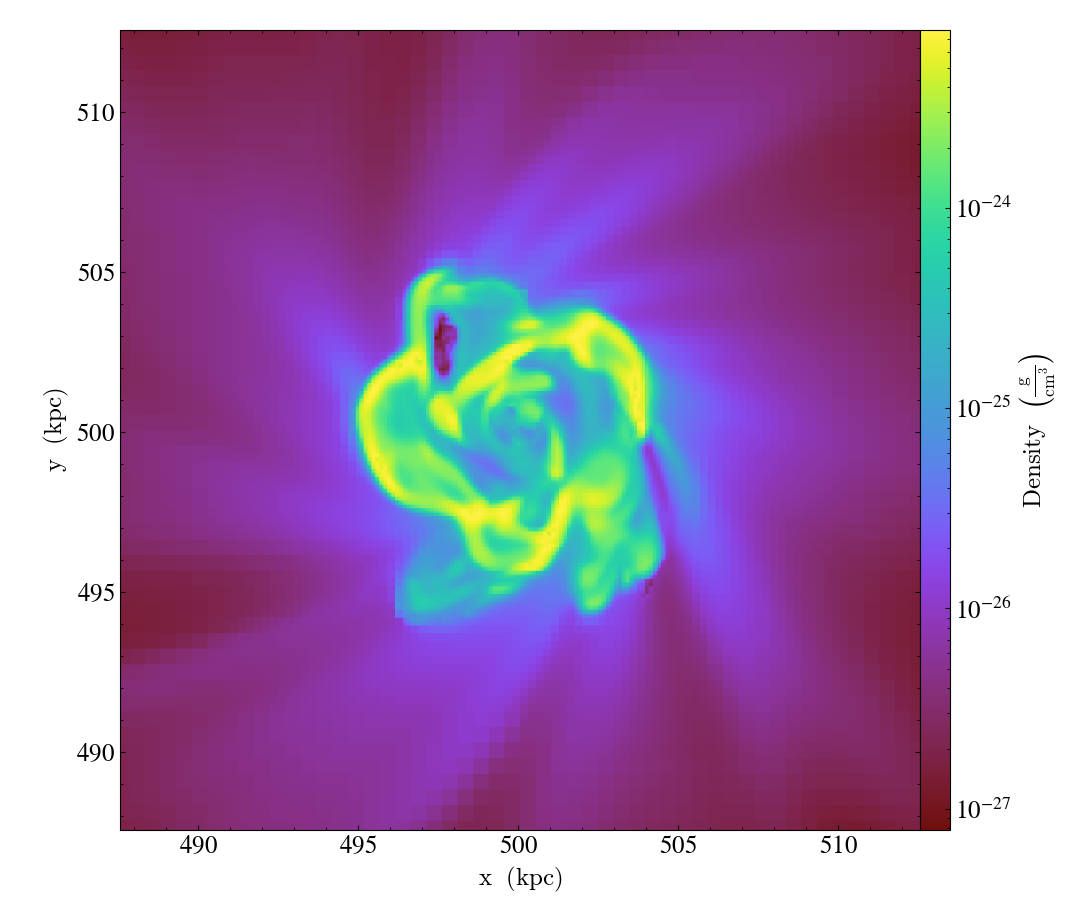

In [18]:
yt.SlicePlot(ds_in_mem, 'z', ('stream', 'density'), origin='native')

yay! on to more interesting stuff...

### `load_uniform_grid` with on demand data-loading via functions

If you read the whole docstring, maybe you caught the entry for the `data` argument:

```
data : dict
    This is a dict of numpy arrays, (numpy array, unit spec) tuples.
    Functions may also be supplied in place of numpy arrays as long as the
    subsequent argument nprocs is not specified to be greater than 1.
    Supplied functions much accepts the arguments (grid_object, field_name)
    and return numpy arrays.  The keys to the dict are the field names.
```


This bit: **`Functions may also be supplied in place of numpy arrays`**

Let's explore that...

By wrapping our full yt dataset with a lazy-evaluation of an arbitrary grid for all of the fields that exist in the original dataset! That sounds fun. 

So what do we need for a function? That docstring entry is maybe a little opaque...

Here's an outline: 

```python

ds = yt.load() # our full dataset! 

def load_field_from_ag(grid_object, field_name):

    # get the extent and shape of the grid_object
    le = # left edge of the grid object
    re = # right edge of the grid object
    shape = # shape of the grid object 

    # construct an abritrary grid on the **full** dataset
    ag = ds.arbitrary_grid(le, re, shape)

    # evaluate the field on the arbitrary grid of the full dataset 
    fixed_res_array = ag[field_name].d  # make it a plain numpy array with the .d
    return fixed_res_array
```

What this does in words is inject a handle to our full yt dataset within a function that can evaluate a field on a grid coming from somewhere else (our wrapping dataset). 

And when building our field dictionary for `load_uniform_grid`, we supply this function instead of a numpy array:

```python
data = {'density': load_field_from_ag,}

ds_wrapper = yt.load_uniform_grid(data, data_shape, ....)
```

and when yt goes to fetch data for the grid, the arbitrary grid will be evalulated on demand. 

Ok, so let's try to actually implement this...

First, let's understand a bit more about what this incoming `grid_object` argument will look like by looking at one of the grids of our base dataset: 

In [19]:
g0 = ds.index.grids[0]
g0

EnzoGrid_0001 ([32 32 32])

from which we can extract the extent and shape of that grid:

In [20]:
g0.LeftEdge, g0.RightEdge, g0.shape

(unyt_array([0., 0., 0.], 'code_length'),
 unyt_array([1., 1., 1.], 'code_length'),
 array([32, 32, 32], dtype=int32))

ok, so let's think about the `field_name` argument a bit too. 

In [32]:
def load_field_from_ag(grid_object, field_name):
    # get the extent and shape of the grid_object
    le = grid_object.LeftEdge  # left edge of the grid object
    re = grid_object.RightEdge # right edge of the grid object 
    shape = grid_object.shape # shape of the grid object 

    # construct an abritrary grid on the **full** dataset    
    ag = ds.arbitrary_grid(le, re, shape)

    # evaluate the field on the arbitrary grid of the full dataset 
    # full_ds_field_name = field_name_map[field_name[1]]  # annoying.    
    full_ds_field_name = ('enzo', field_name[1]) # replace 
    print((field_name, full_ds_field_name))
    fixed_res_array = ag[full_ds_field_name].d  # make it a plain numpy array with the .d
    return fixed_res_array

ok, let's build our field dictionary:

In [33]:
data = {}

for field in ds.field_list:
    # data[field[1]] = load_field_from_ag
    if field[0] == 'enzo':
        data[field[1]] = load_field_from_ag

data.keys()

dict_keys(['Average_creation_time', 'Bx', 'By', 'Bz', 'Cooling_Time', 'Dark_Matter_Density', 'Density', 'Electron_Density', 'Forming_Stellar_Mass_Density', 'Galaxy1Colour', 'Galaxy2Colour', 'HII_Density', 'HI_Density', 'HeIII_Density', 'HeII_Density', 'HeI_Density', 'MBHColour', 'Metal_Density', 'PhiField', 'Phi_pField', 'SFR_Density', 'Star_Particle_Density', 'Temperature', 'TotalEnergy', 'gammaHI', 'kphHI', 'kphHeI', 'kphHeII', 'x-velocity', 'y-velocity', 'z-velocity'])

In [34]:
arbitrary_shape = (256, 256, 256)
arbitrary_bbox = np.array([[.48, .52], 
                           [.48, .52],
                           [.48, .52]])

ds_delayed = yt.load_uniform_grid(data, arbitrary_shape, bbox=arbitrary_bbox, length_unit='Mpc')

yt : [INFO     ] 2025-07-15 10:44:13,541 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-15 10:44:13,542 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-07-15 10:44:13,543 Parameters: domain_left_edge          = [0.48 0.48 0.48]
yt : [INFO     ] 2025-07-15 10:44:13,545 Parameters: domain_right_edge         = [0.52 0.52 0.52]
yt : [INFO     ] 2025-07-15 10:44:13,547 Parameters: cosmological_simulation   = 0


In [35]:
ds_delayed.field_list

[('stream', 'Average_creation_time'),
 ('stream', 'Bx'),
 ('stream', 'By'),
 ('stream', 'Bz'),
 ('stream', 'Cooling_Time'),
 ('stream', 'Dark_Matter_Density'),
 ('stream', 'Density'),
 ('stream', 'Electron_Density'),
 ('stream', 'Forming_Stellar_Mass_Density'),
 ('stream', 'Galaxy1Colour'),
 ('stream', 'Galaxy2Colour'),
 ('stream', 'HII_Density'),
 ('stream', 'HI_Density'),
 ('stream', 'HeIII_Density'),
 ('stream', 'HeII_Density'),
 ('stream', 'HeI_Density'),
 ('stream', 'MBHColour'),
 ('stream', 'Metal_Density'),
 ('stream', 'PhiField'),
 ('stream', 'Phi_pField'),
 ('stream', 'SFR_Density'),
 ('stream', 'Star_Particle_Density'),
 ('stream', 'Temperature'),
 ('stream', 'TotalEnergy'),
 ('stream', 'gammaHI'),
 ('stream', 'kphHI'),
 ('stream', 'kphHeI'),
 ('stream', 'kphHeII'),
 ('stream', 'x-velocity'),
 ('stream', 'y-velocity'),
 ('stream', 'z-velocity')]

(('stream', 'Density'), ('enzo', 'Density'))


yt : [INFO     ] 2025-07-15 10:44:20,143 xlim = 0.480000 0.520000
yt : [INFO     ] 2025-07-15 10:44:20,143 ylim = 0.480000 0.520000
yt : [INFO     ] 2025-07-15 10:44:20,147 xlim = 0.479950 0.519946
yt : [INFO     ] 2025-07-15 10:44:20,148 ylim = 0.479950 0.519946
yt : [INFO     ] 2025-07-15 10:44:20,151 Making a fixed resolution buffer of (('stream', 'Density')) 800 by 800



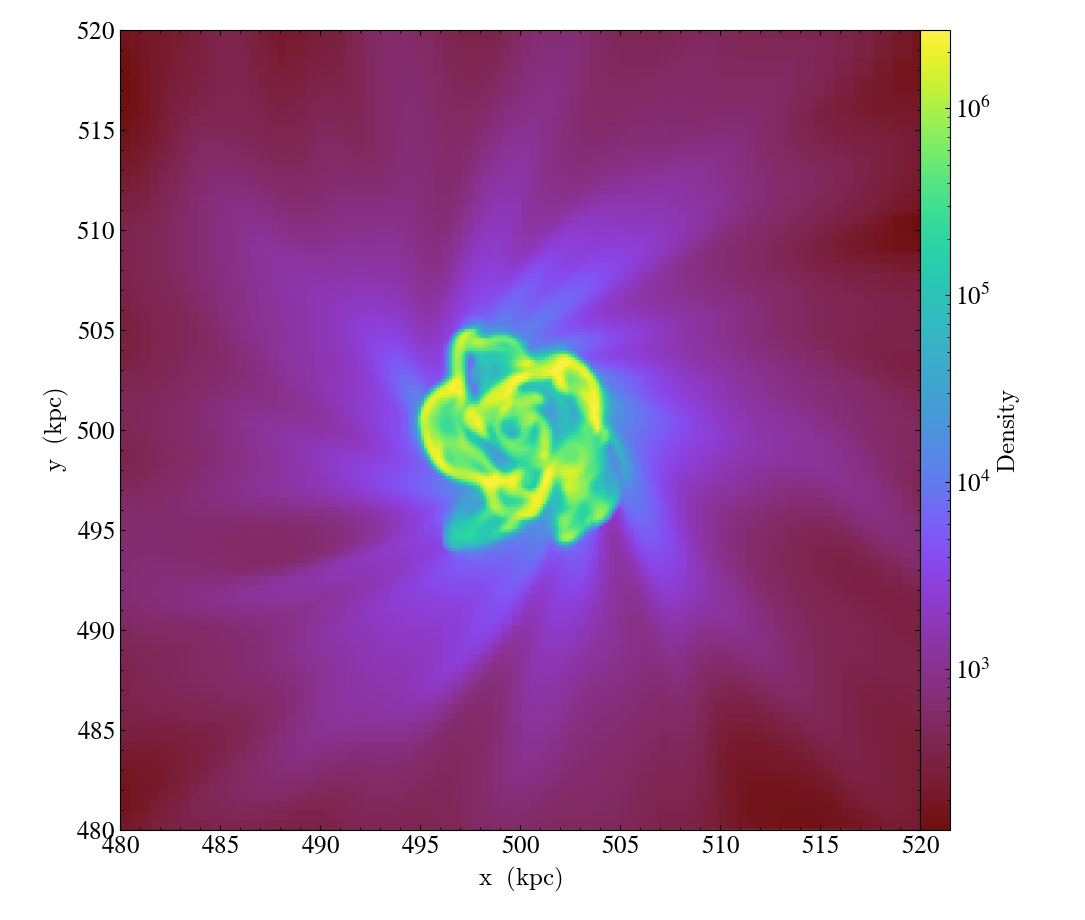

In [36]:
yt.SlicePlot(ds_delayed, 'z', ('stream', 'Density'), origin='native')

In [153]:
ds.domain_right_edge.to('Mpc')

unyt_array([1.00010449, 1.00010449, 1.00010449], 'Mpc')

[480. 480. 480.] kpc [520. 520. 520.] kpc [256 256 256]


yt : [INFO     ] 2025-07-14 15:24:01,781 xlim = 0.480000 0.520000
yt : [INFO     ] 2025-07-14 15:24:01,782 ylim = 0.480000 0.520000
yt : [INFO     ] 2025-07-14 15:24:01,787 xlim = 0.480000 0.520000
yt : [INFO     ] 2025-07-14 15:24:01,789 ylim = 0.480000 0.520000
yt : [INFO     ] 2025-07-14 15:24:01,791 Making a fixed resolution buffer of (('stream', 'Density')) 800 by 800



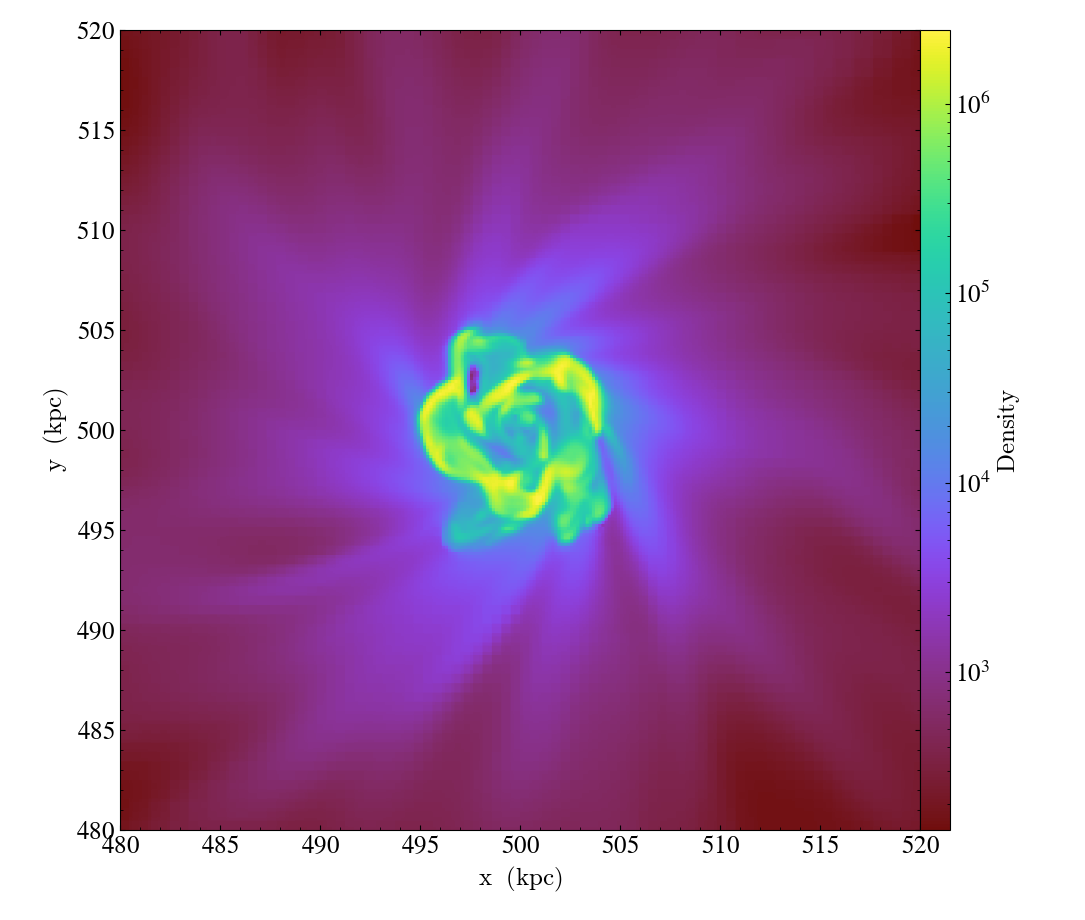

In [154]:
yt.SlicePlot(ds_delayed, 'z', ('stream', 'Density'), origin='native')

[480. 480. 480.] kpc [520. 520. 520.] kpc [256 256 256]


yt : [INFO     ] 2025-07-14 15:24:14,784 xlim = 0.480000 0.520000
yt : [INFO     ] 2025-07-14 15:24:14,787 ylim = 0.480000 0.520000
yt : [INFO     ] 2025-07-14 15:24:14,795 xlim = 0.480000 0.520000
yt : [INFO     ] 2025-07-14 15:24:14,797 ylim = 0.480000 0.520000
yt : [INFO     ] 2025-07-14 15:24:14,801 Making a fixed resolution buffer of (('stream', 'Temperature')) 800 by 800



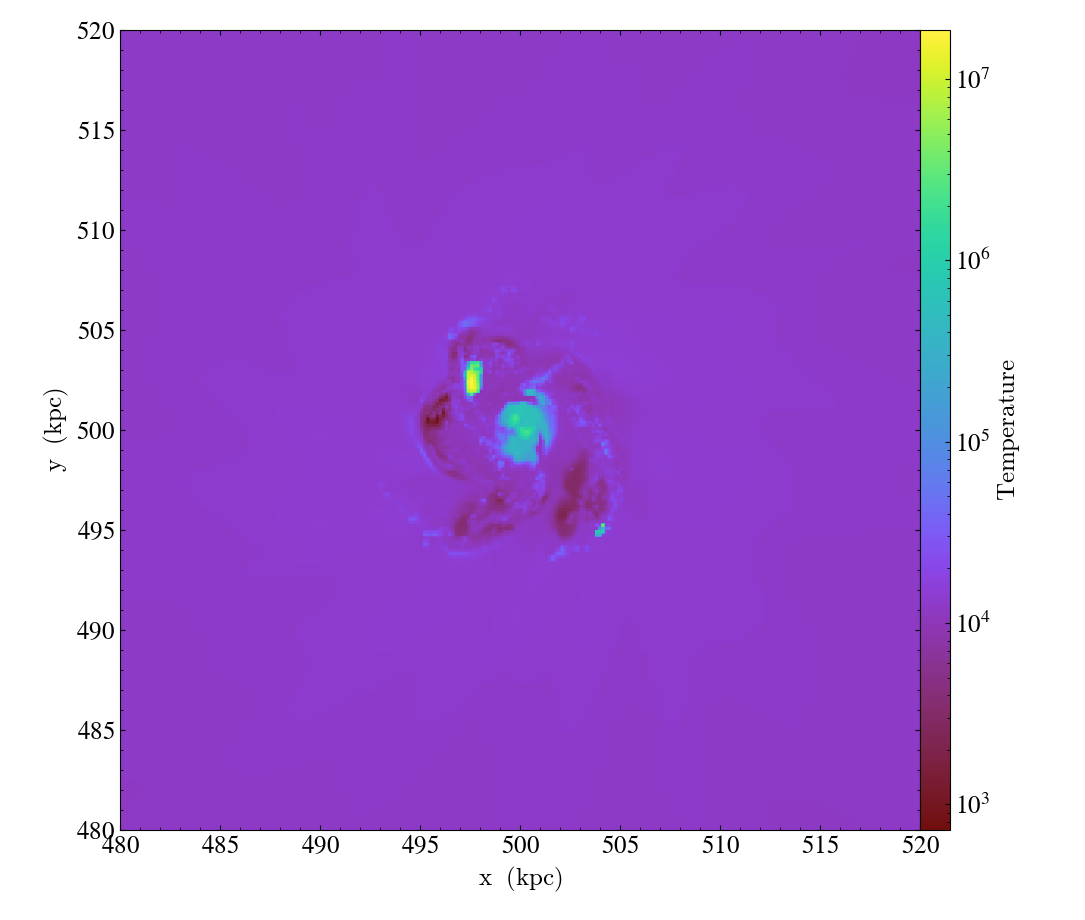

In [155]:
yt.SlicePlot(ds_delayed, 'z', ('stream', 'Temperature'), origin='native')

Ok... but why??

The `ds` reference in:

```python
def load_field_from_ag(grid_object, field_name):

    # grid_object is for the wrapping dataset
    le = ds.arr(grid_object.LeftEdge.to('kpc').d, 'kpc')
    re = ds.arr(grid_object.RightEdge.to('kpc').d, 'kpc')
    shape = grid_object.shape

    
    ag = ds.arbitrary_grid(le, re, shape)

    print(le, re, shape)
    
    return ag[field_name_map[field_name[1]]].d
```

Could be anything! 

* handle to an open h5py file (`yt.load_hdf5_file`)
* handle to an open xarray dataset (`yt_xarray`)
* a dask array
* a zarr store
* ......


## `load_amr_grids` 

The following example builds a block-AMR grid by recursively dividing a bounding grid by 2 at each level and populating data at each level. 

For each level, there is a single grid, defined by a grid dictionary object of the form:

```python
grid = {
        "left_edge": le_i,
        "right_edge": re_i,
        "dimensions": sz_i,
        "level": lev,
        ("stream", "density"): levp1_noisy,
        ("stream", "lev_p1"): levp1,
    }
```

* `left_edge` and `right_edge`: the 3D left/right corners of the grid
* `dimensions`: the shape of the grid
* `level`: the refinement level
* `("stream", "density")` and `("stream", "lev_p1")` some data fields so we can plot


In [111]:
# set our global bounding box
bbox = np.array([[-1., 1.], 
                 [-1., 1.], 
                 [-1., 1.]])

# size of the coarsest grid (level 0)
sz_0 = np.array((64, 64, 64))

# max refinement levels
max_lev = 4

# calculate box width, box center, grid spacing for level 0
bbox_wid = bbox[:, 1] - bbox[:, 0]
bbox_c = np.mean(bbox, axis=1)
dd0 = bbox_wid / sz_0

# iterate over grid levels
sz_i = sz_0.copy()
grids = []  # container for each grid dictionary
for lev in range(max_lev):

    # calculate the current grid's bounding box width
    box_wid_factor = 2.0 * int(lev > 0) + int(lev == 0) * 1.0
    bbox_wid = bbox_wid / box_wid_factor

    # calculate the left/right edges
    le_i = bbox_c - bbox_wid / 2.0
    re_i = bbox_c + bbox_wid / 2.0

    # find closest start/end index in lev 0 grid
    start_i = np.round(le_i / dd0).astype(int)
    end_i = np.round(re_i / dd0).astype(int)
    sz_0 = end_i - start_i

    # recompute for rounding errors (watch out!)
    le_i = start_i * dd0
    re_i = le_i + sz_0 * dd0

    # the size of the current level
    sz_i = sz_0 * 2**lev

    # calculate some fields for this level
    levp1 = np.full(sz_i, lev + 1.0)
    levp1_noisy = levp1_noisy + np.random.random(sz_i) - 0.5

    # define the grid dictionary
    grid = {
        "left_edge": le_i,
        "right_edge": re_i,
        "dimensions": sz_i,
        "level": lev,
        ("stream", "density"): levp1_noisy,
        ("stream", "lev_p1"): levp1,
    }
    grids.append(grid)

ds = yt.load_amr_grids(
    grids,
    sz_0,
    bbox=bbox,
    length_unit='m',    
)

NameError: name 'levp1_noisy' is not defined

yt : [INFO     ] 2025-07-14 14:44:43,608 xlim = -1.000000 1.000000
yt : [INFO     ] 2025-07-14 14:44:43,610 ylim = -1.000000 1.000000
yt : [INFO     ] 2025-07-14 14:44:43,615 xlim = -1.000000 1.000000
yt : [INFO     ] 2025-07-14 14:44:43,616 ylim = -1.000000 1.000000
yt : [INFO     ] 2025-07-14 14:44:43,622 Making a fixed resolution buffer of (('stream', 'density')) 800 by 800



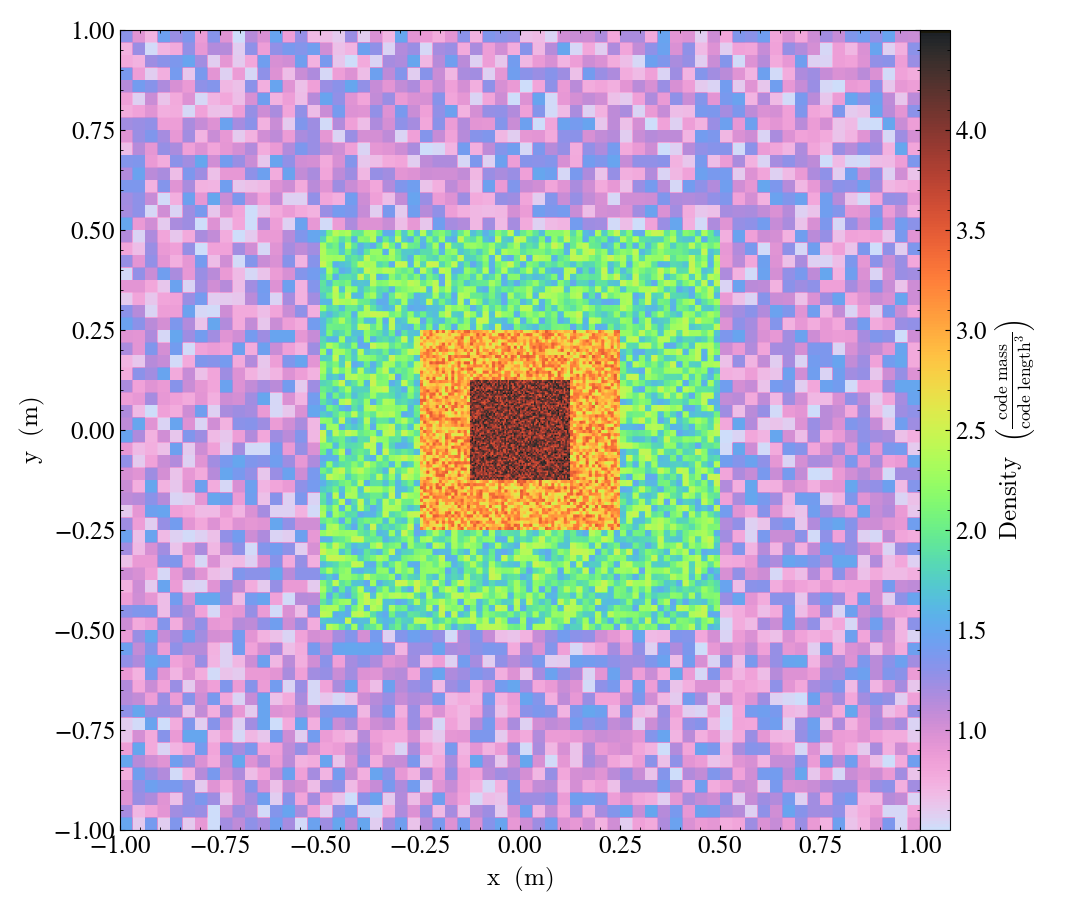

In [43]:
slc = yt.SlicePlot(ds, 'z', ('stream', 'density'))
slc.set_log(('stream', 'density'), False)
slc.set_cmap(('stream', 'density'), 'cmyt.pastel_r')
slc


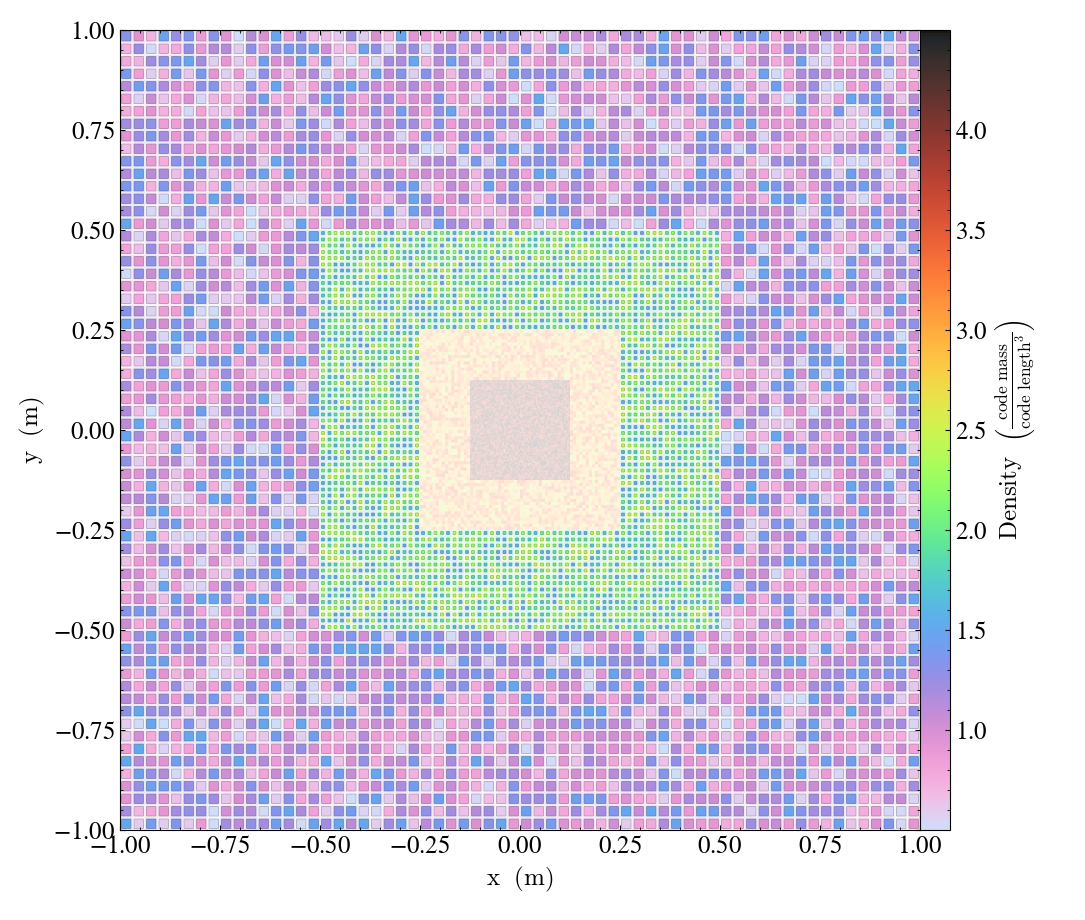

In [44]:
slc.annotate_cell_edges(color=(1., 1., 1.), alpha= 0.8)
slc


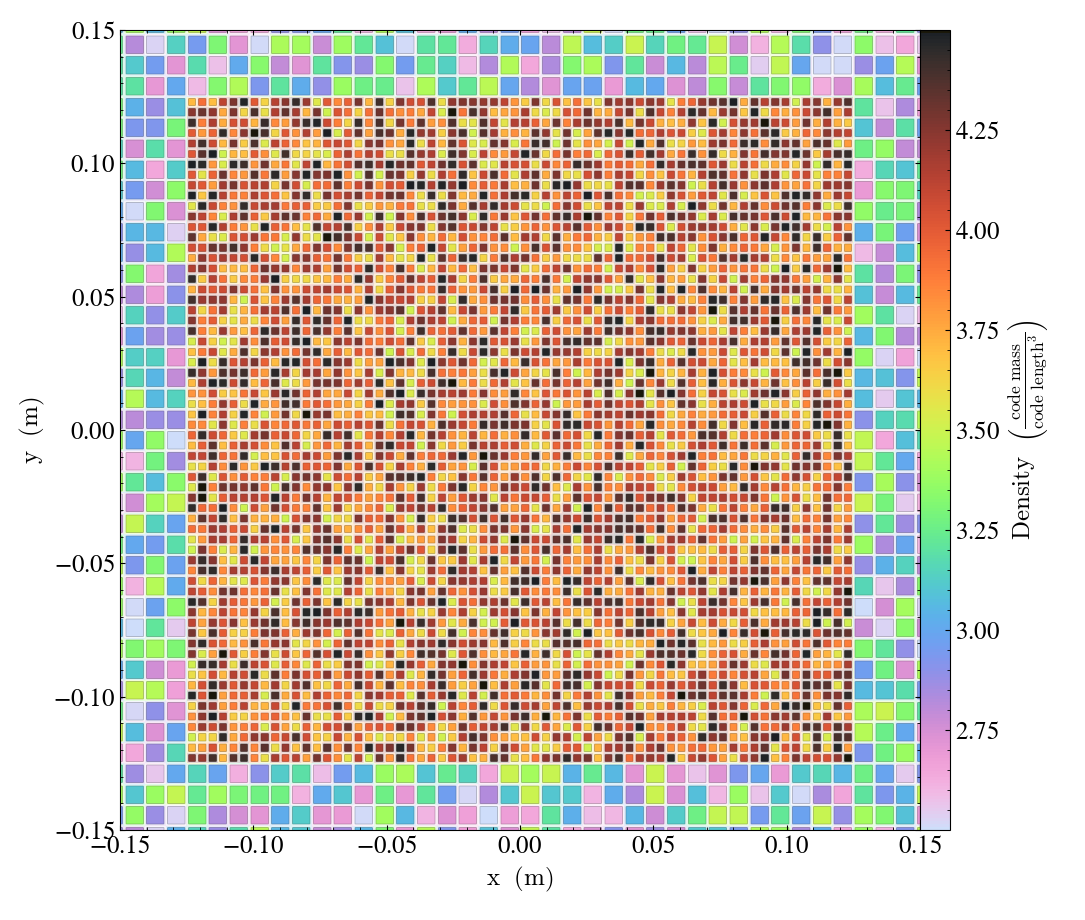

In [45]:
slc.set_width(0.3, 'm')